# Text Classification with AG's News Topics - Python API

*We recommend using a GPU runtime for this example. In the Colab menu bar, choose **Runtime** > **Change Runtime Type** and choose **GPU** under Hardware Accelerator.*

In this notebook, we will show how to use the Ludwig Python API to:


1.   [Download a Dataset](#scrollTo=Download_Dataset)
2.   [Train a Ludwig Model](#scrollTo=Train)
3.   [Evaluate the trained model](#scrollTo=Evaluate)
4.   [Visualize training and test metrics](#scrollTo=Visualize_Metrics)
5.   [Make predictions on New Data](#scrollTo=Make_Predictions_on_New_Data)


In [1]:
# Prerequisite: Install the latest version of Ludwig in the Colab environment
!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 134 kB 7.4 MB/s 
     |████████████████████████████████| 332 kB 47.9 MB/s 
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 1.1 MB 42.3 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 144 kB 28.3 MB/s 
     |████████████████████████████████| 271 kB 17.3 MB/s 


# Download Dataset

We'll be using AG's news topic classification dataset, a common benchmark dataset for text classification. This dataset is a subset of the full AG news dataset, constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.


This dataset contains three columns:

| column      | description                                                |
|-------------|------------------------------------------------------------|
| class_index | 1-4: "world", "sports", "business", "sci/tech" respectively |
| title       | Title of the news article                                  |
| description | Description of the news article                            |


In [10]:
from ludwig.datasets import agnews

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = agnews.load()

# Prints a preview of the first five rows.
train_df.head(5)

,class_index,title,description
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...


The following cell adds a new column `class` populated by the text clas names derived from `class_index`. This preprocessing step is optional, but it helps to make predictions more readable.

In [24]:
# Maps class_index to class name.
class_names = ['<UNK>', 'world', 'sports', 'business', 'sci/tech']

# Adds new column 'class' by mapping class indexes to strings.
train_df['class'] = train_df.class_index.apply(lambda i: class_names[i])
test_df['class'] = test_df.class_index.apply(lambda i: class_names[i])

train_df.head()

Training: 100%|██████████| 1971/1971 [02:50<00:00, 11.59it/s]


,class_index,title,description,class
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,business
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,business
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,business
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",business
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,business


# Train

## Define ludwig config

The Ludwig config declares the machine learning task. It tells Ludwig what to predict, what columns to use as input, and optionally specifies the model type and hyperparameters.

Here, for simplicity, we'll try to predict **class** from **title**.

In [45]:
config = {
  "input_features": [
    {
      "name": "title",            # The name of the input column
      "type": "text",             # Data type of the input column
      "encoder": "parallel_cnn",  # The model architecture we should use for
                                  # encoding this column
    }
  ],
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "epochs": 3,  # We'll train for three epochs. Training longer might give
                  # better performance.
  }
}

## Create a model from config



In [28]:
import logging
from ludwig.api import LudwigModel

# Constructs Ludwig model from config dictionary
model = LudwigModel(config, logging_level=logging.INFO)

## Train the model

In [29]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run_3                                                   │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.5rc2'                                                                                │
├──────────────────┼─────────

# Evaluate

In [43]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

Evaluation: 100%|██████████| 60/60 [00:01<00:00, 55.52it/s]

===== class =====
accuracy: 0.8706408739089966
hits_at_k: 0.9888142943382263
loss: 0.38850072026252747
overall_stats: { 'avg_f1_score_macro': 0.8699319583749664,
  'avg_f1_score_micro': 0.8706408737991841,
  'avg_f1_score_weighted': 0.8699371041571304,
  'avg_precision_macro': 0.8709900364958856,
  'avg_precision_micro': 0.8706408737991841,
  'avg_precision_weighted': 0.8706408737991841,
  'avg_recall_macro': 0.8706297635874837,
  'avg_recall_micro': 0.8706408737991841,
  'avg_recall_weighted': 0.8706408737991841,
  'kappa_score': 0.8275203496338216,
  'token_accuracy': 0.8706408737991841}
per_class_stats: {<UNK>: {   'accuracy': 1.0,
    'f1_score': 0,
    'fall_out': 0.0,
    'false_discovery_rate': 1.0,
    'false_negative_rate': 1.0,
    'false_negatives': 0,
    'false_omission_rate': 0.0,
    'false_positive_rate': 0.0,
    'false_positives': 0,
    'hit_rate': 0,
    'informedness': 0.0,
    'markedness': 0.0,
    'mat

# Visualize Metrics

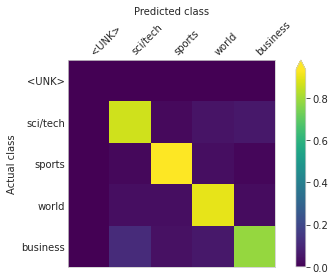

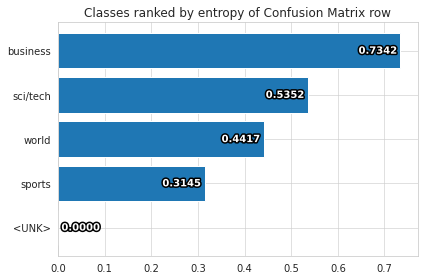

In [42]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

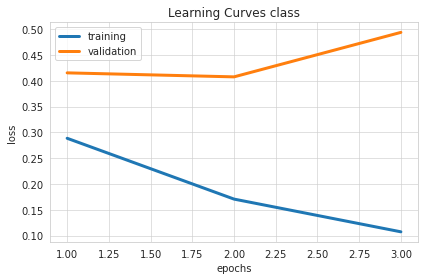

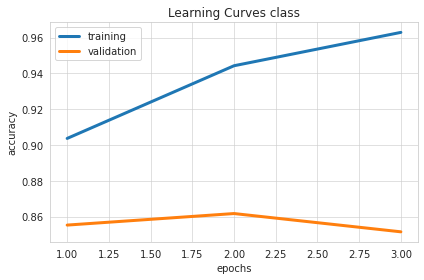

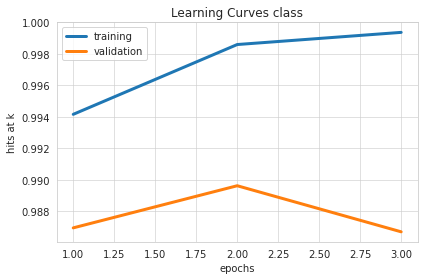

In [34]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')

# Make Predictions on New Data

Lastly we'll show how to generate predictions for new data.

The following are some recent news headlines. Feel free to edit or add your own strings to text_to_predict to see how the newly trained model classifies them.

In [46]:
import pandas as pd

text_to_predict = pd.DataFrame({
  "title": [
    "Google may spur cloud cybersecurity M&A with $5.4B Mandiant buy",
    "Europe struggles to meet mounting needs of Ukraine's fleeing millions",
    "How the pandemic housing market spurred buyer's remorse across America",
  ]
})

predictions, output_directory = model.predict(text_to_predict)

predictions

Prediction: 100%|██████████| 1/1 [00:00<00:00, 214.77it/s]


,class_predictions,class_probabilities,class_probability,class_probabilities_<UNK>,class_probabilities_sci/tech,class_probabilities_sports,class_probabilities_world,class_probabilities_business
0,sci/tech,"[3.604092801978709e-09, 0.9233424663543701, 7....",0.923342,3.604093e-09,0.923342,0.000070,0.002225,0.074362
1,world,"[4.524567387420575e-08, 0.004361735191196203, ...",0.990107,4.524567e-08,0.004362,0.000636,0.990107,0.004895
2,business,"[1.6112302319015726e-06, 0.3999878168106079, 0...",0.525190,1.611230e-06,0.399988,0.000465,0.074356,0.525190
